In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
#Load dataset
df = pd.read_excel(r"C:\Users\Client\OneDrive - Queen Mary, University of London\PhD Shared folder\SomaScan Results\Corelation data.xlsx", sheet_name='COX data')
df.head()


,Group ID,Study ID,Event Name,Gender,MND type,Site of onset,Motor neurone-dominant features from onset,Date of birth,Sample Date,Age at visit,...,C5,TPP2,C3,TSC22D1,PLEC,TF,BCL2L1,EIF4A3,CHGB,NEFH
0,ALS F1,UCH00136,Index-Case Baseline,female,ALS,"Bulbar, UL",NaN,1935-09-18,2014-09-25,79,...,15.364966,11.293299,12.450258,10.493055,8.532551,18.095873,11.726218,8.915282,8.866352,8.518063
1,ALS F10,UCH00153,Index-Case Baseline,male,ALS,Bulbar,NaN,1941-10-18,2015-08-13,73,...,15.366326,11.280191,12.980086,10.497453,8.492654,18.134419,10.533330,8.873136,9.021813,9.932953
2,ALS F11,UCH00093,Index-Case Baseline,male,ALS,LL,NaN,1937-01-27,2013-12-19,76,...,15.290541,9.816824,12.278014,10.048078,9.548629,17.905072,10.316395,8.997462,9.239360,8.434628
3,ALS F12,UCH00142,Index-Case Baseline,male,ALS,LL,NaN,1946-06-11,2015-01-29,68,...,15.750880,10.727155,13.148445,10.454608,8.628263,18.158875,11.030667,8.862327,9.508389,8.939873
4,ALS F13,BUH00447,Index-Case Baseline,male,ALS,Bulbar,PBP - Progressive Bulbar Palsy,1937-04-18,2017-06-28,80,...,15.224337,10.149620,11.866545,10.509775,8.776104,17.947340,10.927111,8.867279,9.395534,8.514122


In [66]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [67]:
clinical_features = [
    "progression_rate_at_baseline",
    "diagnostic_delay",
    "age_at_onset",
    "alsfrsr"
]

protein_features = [
    "islr2","gstp1","nrxn3","apoa4","dazap1","ehd2","c5","tpp2","c3","tsc22d1",
    "plec","tf","bcl2l1","eif4a3","chgb","nefh","tnr","apol1","nudt16l1"
]

all_features = clinical_features + protein_features



In [69]:
# ---- 3) Target definition (binary survival ≥2 years) ----
df["survival_months"] = pd.to_numeric(df["survival"], errors="coerce")
df["event"] = (~df["rip_date"].isna()).astype(int)

cutoff = 24  # months
def survived_cutoff(row):
    if row["event"] == 1:
        return int(row["survival_months"] >= cutoff)
    else:
        return int(row["survival_months"] >= cutoff)

df["surv_2y"] = df.apply(survived_cutoff, axis=1)

In [70]:
print(df.columns.tolist())

['group_id', 'study_id', 'event_name', 'gender', 'mnd_type', 'site_of_onset', 'motor_neurone-dominant_features_from_onset', 'date_of_birth', 'sample_date', 'age_at_visit', 'date_first_weakness_noticed', 'date_of_diagnosis', 'diagnostic_delay', 'age_at_onset', 'time_from_onset', 'alsfrsr', 'progression_rate_at_baseline', 'rip_date', 'rip_age', 'survival', 'features_of_fronto-temporal_involvement', 'als_diagnostic_classification', 'on_riluzole', 'tnr', 'apol1', 'nudt16l1', 'islr2', 'gstp1', 'nrxn3', 'apoa4', 'dazap1', 'ehd2', 'c5', 'tpp2', 'c3', 'tsc22d1', 'plec', 'tf', 'bcl2l1', 'eif4a3', 'chgb', 'nefh', 'survival_months', 'event', 'surv_2y']


In [71]:
# ---- 4) Prepare data ----
X = df[all_features].apply(pd.to_numeric, errors="coerce")
y = df["surv_2y"]

# Drop rows with missing values
mask = X.notnull().all(axis=1)
X = X[mask]
y = y[mask]

In [72]:
# ---- 5) Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [73]:

# ---- 6) Random Forest ----
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [74]:
# ---- 7) Evaluation ----
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7333333333333333
ROC AUC: 0.8200000000000001
F1 Score: 0.8333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.71      1.00      0.83        10

    accuracy                           0.73        15
   macro avg       0.86      0.60      0.58        15
weighted avg       0.81      0.73      0.67        15



In [75]:
# ---- 8) Feature importance ----
importances = rf.feature_importances_
feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False)


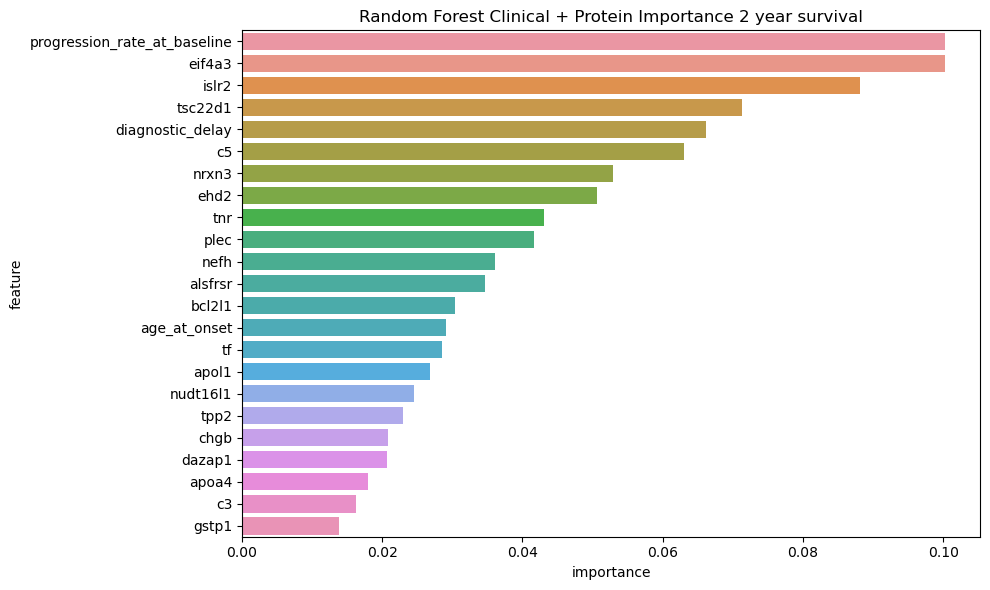

In [76]:
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Random Forest Clinical + Protein Importance 2 year survival")
plt.tight_layout()
plt.show()


🌳 Random Forest
A machine learning method that builds many decision trees and averages them.

Great at finding non‑linear patterns and interactions between variables.

Usually used for classification (yes/no) or regression (predict a number).

⚖️ Cox Proportional Hazards
A statistical survival model.

Estimates how different factors change the risk of an event over time (hazard).

Assumes that the effect of predictors is constant over time (proportional hazards).

🔗 Random Forest with Cox Proportional Hazards (Random Survival Forest)
Combines the flexibility of Random Forest with the time‑to‑event focus of Cox models.

Instead of predicting just “alive or dead,” it predicts the whole survival curve for each patient.

Handles censoring (patients still alive at last follow‑up).

Doesn’t require the proportional hazards assumption — so it can capture more complex relationships than Cox alone.

🧩 Model 1: Cox Proportional Hazards (time‑to‑event survival model)
Goal: Estimate the hazard (risk of death) over time, accounting for censoring (patients still alive at last follow‑up).

Output: Survival probabilities at specific time points (e.g., 2 years, 5 years).

Strengths:

Uses the exact survival time and whether the event occurred.

Handles censored data correctly.

Provides interpretable hazard ratios for each predictor.

Limitations:

Assumes proportional hazards (effect of predictors is constant over time).

Sensitive to collinearity between predictors (your convergence error).

In [62]:
# ---- 3) Target definition (binary survival ≥2 years) ----
df["survival_months"] = pd.to_numeric(df["survival"], errors="coerce")
df["event"] = (~df["rip_date"].isna()).astype(int)

cutoff = 60  # months
def survived_cutoff(row):
    if row["event"] == 1:
        return int(row["survival_months"] >= cutoff)
    else:
        return int(row["survival_months"] >= cutoff)

df["surv_5y"] = df.apply(survived_cutoff, axis=1)

# ---- 4) Prepare data ----
X = df[all_features].apply(pd.to_numeric, errors="coerce")
y = df["surv_5y"]

# Drop rows with missing values
mask = X.notnull().all(axis=1)
X = X[mask]
y = y[mask]

# ---- 5) Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# ---- 6) Random Forest ----
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)
# ---- 7) Evaluation ----
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# ---- 8) Feature importance ----
importances = rf.feature_importances_
feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False)




Accuracy: 0.8
ROC AUC: 0.91
F1 Score: 0.5714285714285715

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.40      0.57         5

    accuracy                           0.80        15
   macro avg       0.88      0.70      0.72        15
weighted avg       0.85      0.80      0.77        15



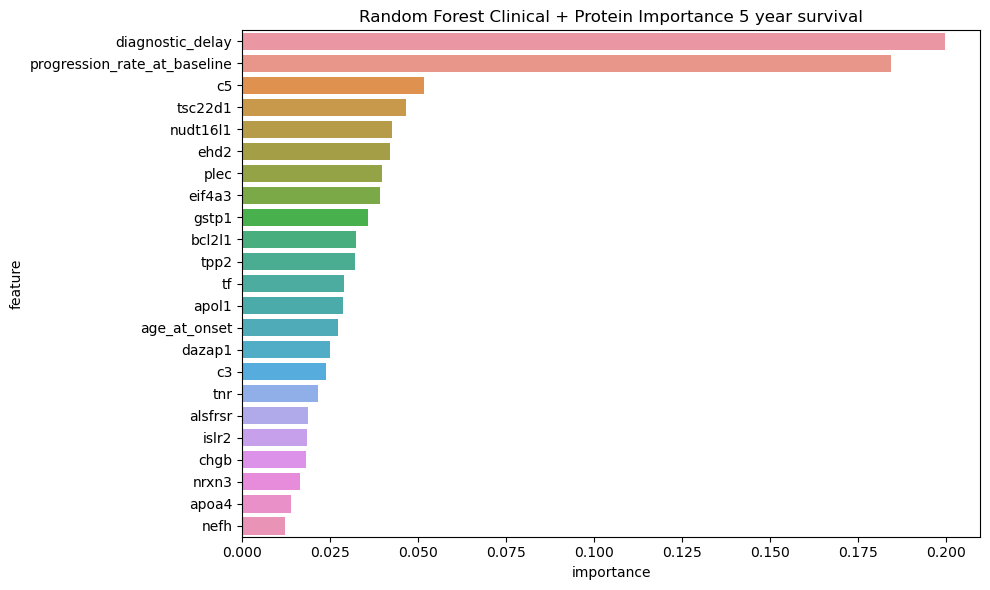

In [63]:
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Random Forest Clinical + Protein Importance 5 year survival")
plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

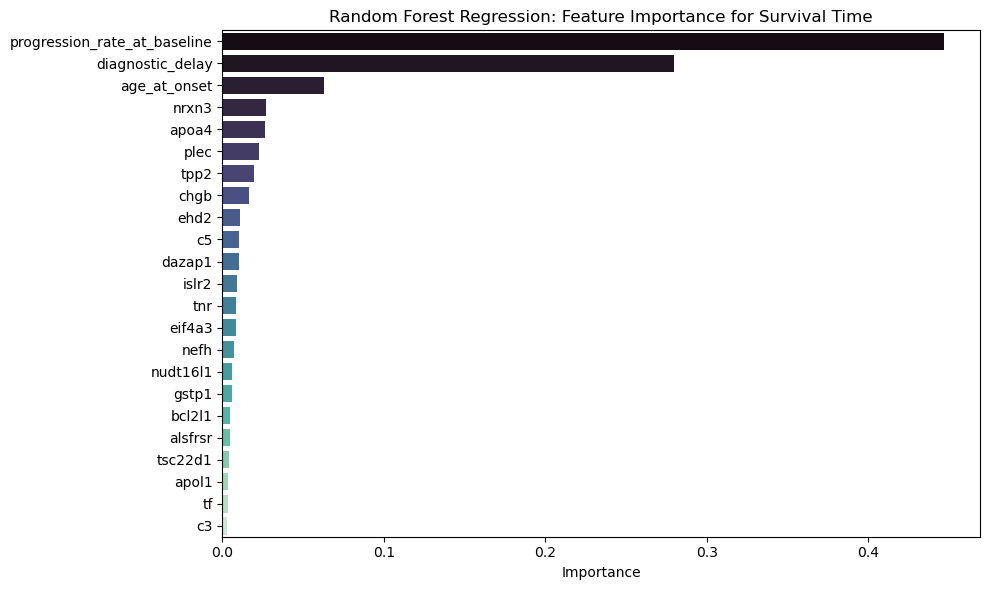

In [26]:
# ---- 2) Define predictors and target ----
# Clinical + protein features (all lowercase now)
predictors = [
    "progression_rate_at_baseline",
    "diagnostic_delay",
    "age_at_onset",
    "alsfrsr",
    "islr2","gstp1","nrxn3","apoa4","dazap1","ehd2","c5","tpp2","c3","tsc22d1",
    "plec","tf","bcl2l1","eif4a3","chgb","nefh","tnr","apol1","nudt16l1"
]

target = "survival"   # survival time column (already in months in your sheet)

# ---- 3) Prepare data ----
df_model = df[predictors + [target]].dropna()
X = df_model[predictors]
y = df_model[target]

# ---- 4) Normalize predictors ----
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=predictors)

# ---- 5) Fit Random Forest Regressor ----
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# ---- 6) Feature importance ----
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# ---- 7) Plot ----
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(X.columns)[indices], palette='mako')
plt.title('Random Forest Regression: Feature Importance for Survival Time')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

🧩 Model 2: Random Forest (classification or regression)
Goal (regression): Predict the numeric survival time directly.

Goal (classification): Predict binary outcome (e.g., survived ≥2 years).

Output: Either a continuous survival time estimate or a probability of surviving past a cutoff.

Strengths:

Non‑parametric, no proportional hazards assumption.

Captures nonlinear relationships and interactions.

More robust to collinearity.

Limitations:

Does not handle censoring properly — censored patients are treated as if their survival time is known.

Predictions can be biased if censoring is common.

Less interpretable than CoxPH.